# TP2 INF372 : APPRENTISSAGE SUPERVISE ET NON SUPERVISE

This involves implementing an K-NN(K Nearest Neighbour) for the classification of data from the MNIST dataset which is a set of images of handwritten digits.
For this exercise, we will use the pytorch package.

In [6]:
pip install pykeops

In [7]:
#Standard imports

import time

import torch
from matplotlib import pyplot as plt

from pykeops.torch import LazyTensor

use_cuda = torch.cuda.is_available()
tensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [8]:
try:
    from sklearn.datasets import fetch_openml
except ImportError:
    raise ImportError("This tutorial requires Scikit Learn version >= 0.20.")

mnist = fetch_openml("mnist_784", cache=True, as_frame=False)

x = tensor(mnist.data.astype("float32"))
y = tensor(mnist.target.astype("int64"))

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [9]:
Ntrain, Ntest = (60000, 10000) if use_cuda else (1000, 100)
x_train, y_train = x[:Ntrain, :].contiguous(), y[:Ntrain].contiguous()
x_test, y_test = (
    x[Ntrain : Ntrain + Ntest, :].contiguous(),
    y[Ntrain : Ntrain + Ntest].contiguous(),
)

In [10]:
K = 3  # N.B.: K has very little impact on the running time

start = time.time()  # Benchmark:

X_i = LazyTensor(x_test[:, None, :])  # (10000, 1, 784) test set
X_j = LazyTensor(x_train[None, :, :])  # (1, 60000, 784) train set
D_ij = ((X_i - X_j) ** 2).sum(
    -1
)  # (10000, 60000) symbolic matrix of squared L2 distances

ind_knn = D_ij.argKmin(K, dim=1)  # Samples <-> Dataset, (N_test, K)
lab_knn = y_train[ind_knn]  # (N_test, K) array of integers in [0,9]
y_knn, _ = lab_knn.mode()  # Compute the most likely label

if use_cuda:
    torch.cuda.synchronize()
end = time.time()

error = (y_knn != y_test).float().mean().item()
time = end - start

print(
    "{}-NN on the full MNIST dataset: test error = {:.2f}% in {:.2f}s.".format(
        K, error * 100, time
    )
)

[KeOps] Generating code for ArgKMin_Reduction reduction (with parameters 0) of formula Sum((a-b)**2) with a=Var(0,784,0), b=Var(1,784,1) ... OK
[pyKeOps] Compiling pykeops cpp cafd668bf8 module ... OK
3-NN on the full MNIST dataset: test error = 20.00% in 8.97s.


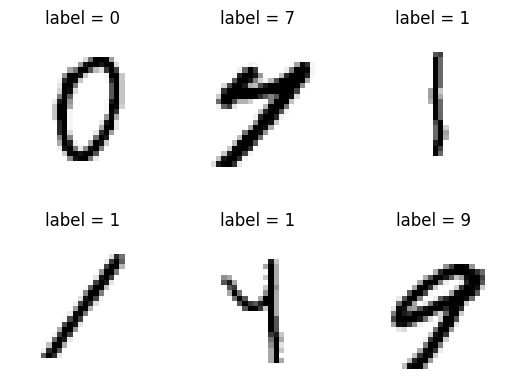

In [11]:
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    ax.imshow((255 - x_test[i]).view(28, 28).detach().cpu().numpy(), cmap="gray")
    ax.set_title("label = {}".format(y_knn[i].int()))
    plt.axis("off")

plt.show()